In [1]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import statsmodels.api as sm
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot
from ur_tests import *

# Téma 5: Stacionarita, sezónní modely

====================== PRO ZVÍDAVÉ ======================


### Matematické okénko do minulosti letem světem :)

**1) součet geometrické řady**
>$$
\frac{1}{1-r} = 1 + r + r^2 + \ldots = 1 + \sum_{i=1}^\infty r^i \qquad\text{pro $|r|<1$.}
$$

**2) jednotková kružnice**
> Připomeňme, že definujeme imaginární jednotku $i^2 = -1$, pomocí které dovedeme řešit výrazy typu $\sqrt{-4}$ (jaký je výsledek?). Zavádíme potom komplexní čísla ve tvaru $z = a+bi$, kde $a$ je reálná složka a $b$ je složka imaginární. Modul komplexního čísla $|z| = \sqrt{a^2 + b^2}$, též absolutní hodnota nebo norma, udává jeho velikost. Komplexní čísla zakreslujeme do kartézských souřadnic, kde vodorovná osa je reálná, svislá imaginární. Jednotková kružnice je kružnice okolo počátku o poloměru 1, tedy množina komplexních čísel s modulem 1.

![circ](img/kruznice.png)

## Stacionarita, její vyšetření a otestování

### Charakteristická rovnice

Z minulé přednášky víme, že AR(p) proces

$$
X_t = \sum_{i=1}^p \phi_i X_{t-i} + \varepsilon_t \qquad \varepsilon_t \sim \mathrm{iid}\  \mathcal{N}(0, \sigma^2)
$$

lze pomocí operátoru zpoždění zapsat v podobě

$$
\begin{aligned}
\varepsilon_t &= X_t - \phi_1 B^1 X_{t} - \ldots - \phi_p B^p X_{t} \\
&= \left( 1 - \sum_{i=1}^p \phi_i B^i\right) X_t \\
&= \Phi X_t.
\end{aligned}
$$

Podíváme-li se na začátek našeho povídání o AR procesech (2. přednáška), najdeme, že jejich stacionaritu vyšetřujeme pomocí charakteristického polynomu položenému rovno nule,

$$
1 - \beta_1 z - \beta_2 z^2 - \ldots - \beta_p z^p  = 0.
$$

Zavedením $B\equiv z$ a $\phi_i = \beta_i$ je zřejmé, že $\Phi = \left( 1 - \sum_{i=1}^p \phi_i B^i\right)$ je právě tímto polynomem a charakteristická rovnice má tedy tvar

$$\Phi = \left( 1 - \sum_{i=1}^p \phi_i B^i\right) = 1 - \phi_1 B - \ldots \phi_p B^p = 0.$$

> **Věta:**
>
> Buď $\{X_t\}$ procesem AR(p). Potom platí, že $X_t$ je stacionárním procesem právě tehdy, když moduly *kořenů* $b_1,\ldots,b_p$ charakteristické rovnice jsou větší než jedna. Ekvivalentně, totéž platí, pokud *póly* $a_1=1/b_1, \ldots, a_p=1/b_p$ leží uvnitř jednotkové kružnice.

Póly jsou kořeny [reciprokého polynomu](https://en.wikipedia.org/wiki/Reciprocal_polynomial), resp. inverzní charakteristické rovnice - charakteristické rovnice vynásobené $B^{-p} = A$.

> **Poznámka:** vynásobíme-li charakteristickou rovnici $B^{-p}\equiv A$, dostaneme inverzní charakteristickou rovnici
>
> $$
A^p - \phi_1 A^{p-1} - \ldots - \phi_{p} = 0.
$$
>
> Její kořeny jsou právě výše zmíněné póly $a_1, \ldots, a_p$. Literatura je v tomto komplikovaná, pod pojmem *charakteristická rovnice* je myšleno buď jedno, nebo druhé. V teorii diferenčních rovnic spíše to druhé, v teorii AR procesů spíše to první. My se budeme držet prvního formalismu, neboť software zpravidla užívá princip *stacionarita = kořeny vně jednotkové kružnice*.

#### Příklad: AR(1)

Tento příklad už jsme také viděli v kapitole o AR modelech/procesech. Uvažujme proces

$$
X_t = \phi X_{t-1} + \varepsilon_t \qquad\varepsilon_t \sim \mathrm{iid}\ \mathcal{N}(0, \sigma^2),
$$

v řeči operátorů

$$
\Phi X_t = (1-\phi B)X_t = \varepsilon_t.
$$

Charakteristická rovnice a její řešení mají tvar

$$
1- \phi B = 0 \quad \Rightarrow \quad B=b=\frac{1}{\phi}.
$$

Pro stacionaritu musí být kořen $|b|>1$ a tedy $\phi<1$. Případ s jednotkovým kořenem $b=\phi=1$ odpovídá náhodné procházce (ověřte). A konečně $|b|<1$ vede na $\phi>1$ a proces se stává explozivním.

Operátory mají nejednu příjemnou vlastnost. Například inverzi, která v uvedeném AR(1) povede na překvapivé zjištění. S přihlédnutím k výše uvedené sumě geometrické řady pro $\phi<1$ platí

$$
\Phi^{-1} = \frac{1}{1-\phi B} = \left(1 + \sum_{i=1}^{\infty} \phi^i B^i \right)
$$

dostaneme vynásobením AR(1) touto inverzí

$$
\Phi X_t = \varepsilon_t \qquad \Rightarrow \qquad X_t = \Phi^{-1} \varepsilon_t = \left(1+\sum_{i=1}^{\infty} \phi^i B^i\right) \varepsilon_t, 
$$

což je MA($\infty$) proces! Pokud bychom to chtěli ověřit bez operátorů, můžeme psát postupným rozvojem do minulosti

$$
\begin{aligned}
X_t &= \phi X_{t-1} + \varepsilon_t \\
&= \phi (\phi X_{t-2} + \varepsilon_{t-1}) + \varepsilon_t \\
&= \phi^2 X_{t-1} + \phi\varepsilon_{t-1} + \varepsilon_t \\
&= \ldots \\
& = \phi^k X_{t-k} + \sum_{i=0}^{k-1} \phi^k \varepsilon_{t-k}.
\end{aligned}
$$

Je-li $|\phi|<1$, pak pro $k\to\infty$ půjde $\phi^k X_{t-k}\to 0$ a dostáváme opět MA($\infty$).

Je-li $|\phi|>1$, je proces explozivní a není slabě stacionární. Můžeme jej ale i přesto invertovat, přepíšeme-li jej do tvaru vycházejícího z budoucnosti,

$$
\begin{aligned}
X_t &= \phi^{-1} X_{t+1} - \phi^{-1} \varepsilon_{t+1} \\
&= \phi^{-k} X_{t+k} - \sum_{i=1}^k \phi^{-i} \varepsilon_{t+i}.
\end{aligned}
$$

Ačkoliv to nedává mnoho smyslu, i tento proces lze invertovat do MA($\infty$),

$$
X_t = -\sum_{i=1}^\infty \phi^{-i}\varepsilon_{t+i}.
$$

První z reprezentací se ze zjevných důvodů říká kauzální, zatímco druhé nekauzální.

Podobnou úvahou bychom mohli vyšetřovat invertibilitu MA procesů z char. polynomu $\Theta = (1-\theta_i B^i)$, což přeskočíme. Shrňme si ale poznatky:
- čisté AR modely jsou vždy invertibilní do MA($\infty$) (potenciálně s rozdíly v kauzálnosti struktur)
- čisté AR modely mohou být stacionární či nestacionární (podle polohy kořenů char. rce)
- čisté MA modely jsou vždy stacionární (z principu vzniku)
- čisté MA modely mohou být invertibilní do AR($\infty$) nebo ne (podle polohy kořenů char. rce)

================== END OF PRO ZVÍDAVÉ =================

### Testy stacionarity

Rozpoznáváme procesy:
- [**Stacionární**](https://en.wikipedia.org/wiki/Stationary_process#Joint_stationarity) - bez trendu a jednotkových kořenů. Mohou být striktně či slabě stacionární, my uvažujeme především slabou stacionaritu v rámci invariance prvních dvou momentů vůči posunům v čase.
- [**Trend-stacionární**](https://en.wikipedia.org/wiki/Trend-stationary_process) - stacionární po odstranění lineárního či nelineárního trendu. Takové procesy lze zapsat $X_t = f(t) + \varepsilon_t$, kde $f(t)$ je trend coby funkce času a $\varepsilon_t$ je stacionární proces. Příkladem je $X_t = t + \varepsilon_t$. V případě šoku jsou "mean reverting", tj. zkonvergují zpět ke střední hodnotě předepsané trendem.
- [**Stacionární po diferencování**](https://en.wikipedia.org/wiki/Unit_root), též *procesy s jednotkovým kořenem* (angl. unit-root processes) - ty jsou stacionární po tolika diferencováních, kolik mají jednotkových kořenů, ale pouze za předpokladu, že nemají jiné kořeny uvnitř jednotkové kružnice. Příkladem je proces $X_t = X_{t-1} + \varepsilon_t$, tj. náhodná procházka. Nejsou "mean reverting", šok se trvale projeví na dalším vývoji.
- [**Nestacionární**](https://en.wikipedia.org/wiki/Stationary_process#Joint_stationarity)

#### [Rozšířený Dickey-Fullerův test (Augmented Dickey-Fuller test)](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

ADF - rozšířený Dickey-Fullerův - test uvažuje hypotézy

$$
\begin{aligned}
H_0&: \text{Proces má jednotkový kořen} \\
H_1&: \text{Proces nemá jednotkový kořen (ale kořeny vně jedn. kružnice)}
\end{aligned}
$$

Testování je založeno na modelu

$$
\Delta X_t = \alpha + \beta_t + \gamma X_{t-1} + \delta_1 \Delta X_{t-1} +\ldots+ \delta_{p-1}\Delta X_{t-p+1} + \varepsilon_t.
$$

Řád $p$ je stanovován různými postupy, ve `statsmodels` pomocí AIC. Hypotéza o existenci jednotkového kořenu je ekvivalentní k $\gamma=0$, tj. situaci, kdy zpožděná veličina $X_{t-1}$ nemá vliv na současnou hodnotu změny $\Delta X_t$ jinak, než skrze přírůstek $\Delta X_{t-1}$. Statistika DF je podílem odhadu $\hat\gamma$ a odhadu [standardní chyby](https://en.wikipedia.org/wiki/Standard_error) tohoto odhadu (směrodatná odchylka odhadu dělená odmocninou z počtu dat). Za úkol se zamyslete nad tím, jak vypadá test pro AR(1).

#### [Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test](https://en.wikipedia.org/wiki/KPSS_test)

KPSS je neparametrický test sloužící k testu hypotéz

$$
\begin{aligned}
H_0&: \text{Proces je trend-stacionární} \\
H_1&: \text{Proces není stacionární (má jednotkový kořen)}
\end{aligned}
$$

Díky hypotézám je možné rozlišit mezi stacionárním procesem s trendem ($H_0$), který je "mean-reverting", tj. po šoku se vrací k střední hodnotě, a procesem nestacionárním s jednotkovým kořenem, který "mean-reverting" není.

#### Výsledky testů
Obvykle se použijí oba testy a podle výsledků (pozor na správnou interpretaci!):

| **ADF** | **KPSS** | **pravděpodobná vlastnost** |
| --- | --- | --- |
| významný | nevýznamný | **stacionární** |
| nevýznamný | významný | **nestacionární, ex. jednotkový kořen** |
| nevýznamný | nevýznamný | nedostatek evidence, **možná trend-stacionární** |
| významný | významný | heteroskedasticita, strukt. změna... |
    


#### Příklad

V následujícím příkladu můžeme ozkoušet, jaké dávají testy výsledky pro bílý šum, náhodnou procházku a bílý šum s přidaným trendem.

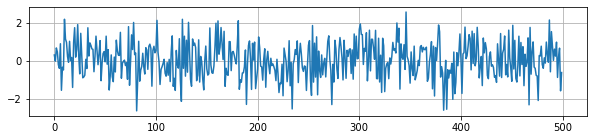

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                -1.424308e+01
p-value                        1.525811e-26
#Lags Used                     1.000000e+00
Number of Observations Used    4.980000e+02
Critical Value (1%)           -3.443549e+00
Critical Value (5%)           -2.867361e+00
Critical Value (10%)          -2.569870e+00
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic           0.112426
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64



/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [127]:
ndat = 500
epsilon = norm.rvs(size=ndat)
df = pd.DataFrame({'whitenoise': epsilon, 
                   'rwalk': np.cumsum(epsilon),
                   'trendstat_linear': epsilon + .01 * np.arange(ndat)})
typ = 'whitenoise'
plt.figure(figsize=(10,2))
plt.plot(df[typ])
plt.show()
adf_test(df[typ])
kpss_test(df[typ])

#### Příklad: I(2) proces

Podívejme se na dvakrát integrovaný proces (bílý šum). Po každém nevýznamném testu zkusíme první diferenci a znovu otestujeme. Samozřejmě bychom měli testovat i KPSS, ale zkusme jen ADF test.

I(2) proces:


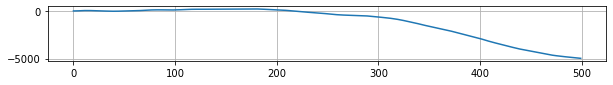

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -1.245306
p-value                          0.653809
#Lags Used                       1.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64

I(2) proces d=1:


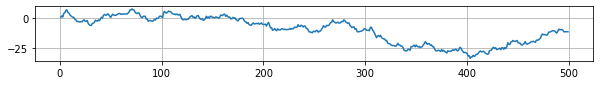

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -1.269575
p-value                          0.642974
#Lags Used                       0.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64

I(2) proces d=2:


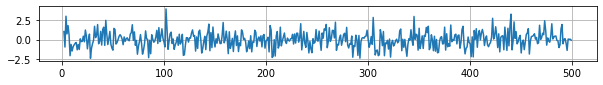

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                 -21.805808
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64



In [130]:
ndat = 500
epsilon = norm.rvs(size=ndat)
df = pd.DataFrame({'I(2)': np.cumsum(np.cumsum(epsilon))})
print('I(2) proces:')
df['I(2)'].plot(figsize=(10,1)); plt.show()
adf_test(df['I(2)'])
print('I(2) proces d=1:')
df['I(2)'].diff().plot(figsize=(10,1)); plt.show()
adf_test(df['I(2)'].diff().dropna())
print('I(2) proces d=2:')
df['I(2)'].diff().diff().plot(figsize=(10,1)); plt.show()
adf_test(df['I(2)'].diff().diff().dropna())

# Modely SARIMA(p,d,q)(P,D,Q)s

Pokud časová řada vykazuje sezónnost, tj. cyklické opakování určitého vývoje *s pevnou periodou*, ARIMA modely stále nebudou stačit. Konkrétně říkáme, že časová řada bez trendu vykazuje sezónnost s periodou $s$, pokud

$$
\mathbb{E}[X_t]=\mathbb{E}[X_{t-s}].
$$

Sezónnost nám často komplikuje situaci, neboť je dalším zdrojem nestacionarity.

Typicky předpokládáme, že perioda $s$ je konstantní, nicméně to samozřejmě není úplně vždy pravda. Data navíc mohou mít více period, např. týdenní a měsíční.

Pokud budeme uvažovat roční sezónnost s měsíčními daty ($s=12$), potom pro predikci $X_t$ budeme potřebovat např.
- $X_{t-12}$ a $X_{t-24}$ při sezónní autoregresi 2. řádu,
- $\varepsilon_{t-12}$ a $\varepsilon_{t-24}$ při sezónním MA 2. řádu.

## Přiblížení stacionaritě (d, D)

Z teorie ARIMA modelů už víme, že ke stacionaritě nás posune diferencování, tedy vytvoření nové řady z rozdílů po sobě jdoucích hodnot,

$$
\nabla X_t = (1-B) X_t = X_t - X_{t-1}.
$$

Toto můžeme dělat $d$ krát, většinou maximálně dvakrát, $\nabla^2 X_t$.

Analogicky můžeme přibližně zestacionárnit i časovou řadu se sezónností s periodou $s$,

$$
\nabla_s X_t = (1-B^s) X_t = X_t - X_{t-s}.
$$

Chceme-li tedy odstraňovat sezónní trend u měsíčních dat, potom bychom postupovali

$$
X_t - X_{t-12} = (1 - B^{12})X_t = \nabla_{12} X_t.
$$

Pozor, sezónní index je dolní, neboť horní vždy říká řád diferencování. Opět můžeme diferencovat víckrát, $\nabla_s^D$, zpravidla maximálně jednou. 

#### Nesezónní trend ale pořád existuje!
Nezapomínejme, že trend nemusí být jen v rámci sezón, ale i v rámci celé časové řady, jak jsme byli dosud zvyklí. Ten jsme odstraňovali pomocí $\nabla^d = (1-B)^d$. Spojíme-li to dohromady, dostaneme diferencování

$$
\nabla_s^D \nabla^d X_t,
$$

tj. řádu $D$ pro sezónní trend a řádu $d$ pro trend globální.

#### Příklad

Vytvořme si jednoduchou řadu ze sinusovky. Proženeme ji absolutní hodnotou a v rámci periody (pozor, ta je nyní $\pi$) ji rovnoměrně navzorkujeme ve 12 bodech. Máme tedy $s=12$. Nagenerovaná data si prohlédneme bez šumu s diferencováním $\nabla_{12} x_t = x_t - x_{t-12}$ a následně zatížená ještě aditivním bílým šumem. Nakonec dojde i na trend globální.

In [4]:
t = np.arange(0, 18*np.pi, step=np.pi/12)
x_clear = np.abs(np.sin(t))
epsilon = norm.rvs(scale=0.1, size=t.size)
df = pd.DataFrame({'t': t,                                 # časový index
                   'x_clear': x_clear,                     # čistá data
                   'x': x_clear + epsilon,                 # data s bílým šumem
                   'rw': np.cumsum(x_clear + epsilon)})    # data s I(1) - náh. procházka

Nejprve čistá data. Zkuste si změnit periodu diferencování a vysledujte, co to udělá s daty.

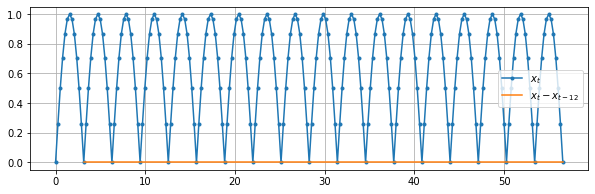

In [5]:
plt.figure(figsize=(10, 3))
plt.plot(df['t'], df['x_clear'], '-', marker='.', label=r'$x_t$')
plt.plot(df['t'], df['x_clear'].diff(12), label=r'$x_t - x_{t-12}$')
plt.legend()
plt.show()

A data se šumem. Uhodnete, co zbylo po diferencování? Nenechte se svést k myšlence, že bílý šum - rozepište si, co se odečítá od čeho! Ideálem by ale samozřejmě byl bílý šum.

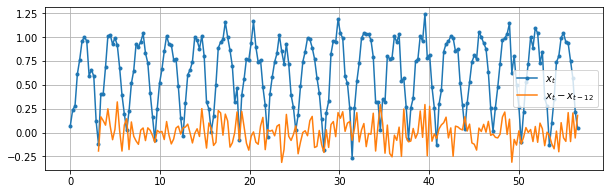

In [6]:
plt.figure(figsize=(10, 3))
plt.plot(df['t'], df['x'], '-', marker='.', label=r'$x_t$')
plt.plot(df['t'], df['x'].diff(12), label=r'$x_t - x_{t-12}$')
plt.legend()
plt.show()

Velké finále: Data s periodou sezónnosti $s=12$, s globálním trendem (náhodná procházka) a různá diferencování - sezónní, nesezónní a obojí, v detailu a globálu:

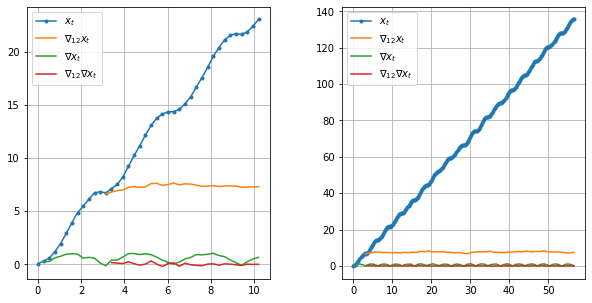

In [7]:
detail = 40
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(df['t'][:detail], df['rw'][:detail], '-', marker='.', label=r'$x_t$')
plt.plot(df['t'][:detail], df['rw'][:detail].diff(12), label=r'$\nabla_{12} x_t$')
plt.plot(df['t'][:detail], df['rw'][:detail].diff(), label=r'$\nabla x_t$')
plt.plot(df['t'][:detail], df['rw'][:detail].diff(12).diff(), label=r'$\nabla_{12} \nabla x_t$')
plt.legend()
plt.subplot(1,2,2)
plt.plot(df['t'], df['rw'], '-', marker='.', label=r'$x_t$')
plt.plot(df['t'], df['rw'].diff(12), label=r'$\nabla_{12} x_t$')
plt.plot(df['t'], df['rw'].diff(), label=r'$\nabla x_t$')
plt.plot(df['t'], df['rw'].diff().diff(12), label=r'$\nabla_{12} \nabla x_t$')
plt.legend()
plt.show()

Na závěr si zkuste pohrát s ACF a PACF jednotlivých složek `df`:

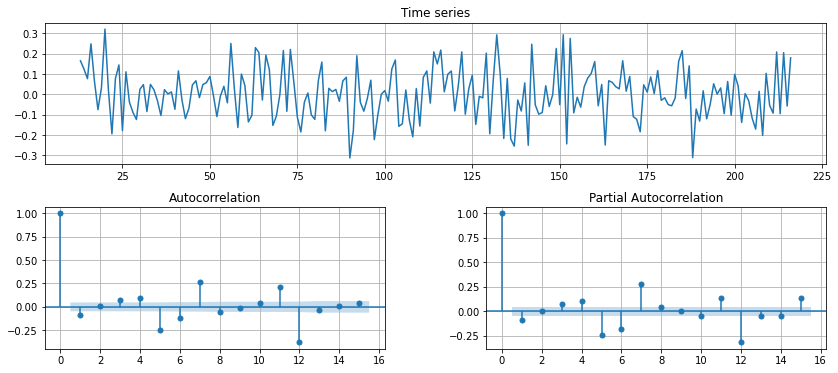

In [8]:
tsplot(df['rw'].diff().diff(12).dropna())

#### Ještě trocha experimentování

Zkusme si zaexperimentovat se sezónním AR modelem:
- AR(1) koeficient $\phi$
- sezónní AR(1) koeficient $\Phi$
- perioda sezónnosti $s$

Takže např. pro nesezónní model AR(1) máme $\Phi=0$ a

$$
Y_t = \phi Y_{t-1} + \varepsilon_t,
$$

zatímco pro čistě sezónní AR(1) model je $\phi=0$ a

$$
Y_t = \Phi Y_{t-s} + \varepsilon_t.
$$

Finálně, model se sezónní i nesezónními autoregresemi 1. řádu bude

$$
Y_t = \phi Y_{t-1} + \Phi Y_{t-s} + \varepsilon_t.
$$

K tomu více viz simulace níže - zkuste měnit koeficienty. Podobně bychom mohli stavět MA modely, ARMA modely a pak už jen přidat výše uvedené diferencování a dostali bychom příslušné modely ARIMA.

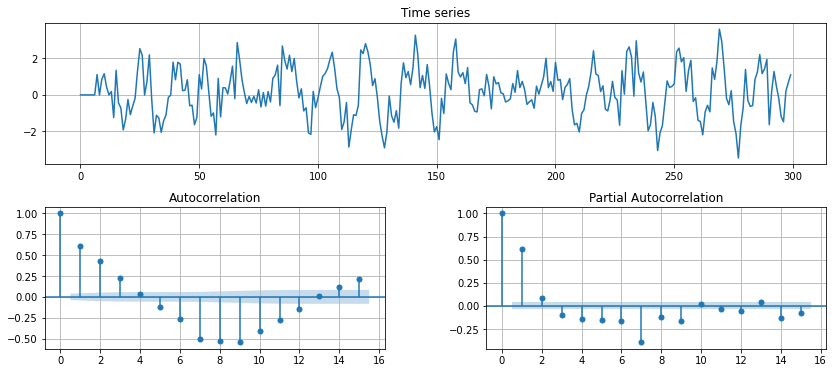

In [9]:
ndat =300
s = 7
y = np.zeros(ndat)
phi = 0.5
Phi = -0.4
for t in range(s, ndat):
    y[t] = phi * y[t-1] + Phi * y[t-s] + norm.rvs()
tsplot(y)

Pozorným pozorováním jsme zajisté zjistili, že ACF a PACF se chovají podobně, jak jsme zvyklí, akorát mají námi očekávané průběhy posunuté v periodách.

## Složitý model versus model sezónní

Z AR, MA, ARMA a ARIMA víme, že modelovat závislosti dat v řadě můžeme do libovolné hloubky. Teoreticky bychom mohli sezónnost zkusit postihnout dostatečně složitým modelem, sahajícím pro veličiny hlouběji v minulosti. To je ovšem v rozporu s požadavkem na jednoduchost modelů. Např. při $s=12$ bychom závislost tří po sobě jdoucích sezón modelovali 36 AR  nebo MA koeficienty! Mnohem jednodušší je uvažovat běžný a sezónní vývoj zvlášť a použít multiplikativní model SARIMA(p,d,q)(P,D,Q)s:

$$
\Phi_P(B^s) \phi_p(B) \nabla_s^D \nabla^d X_t = \theta_q(B) \Theta_Q (B^s)\varepsilon_t
$$

kde

- $\Phi_P(B^s) = (1-\Phi_1 B^s - \ldots - \Phi_p B^{sP})$ je sezónní AR operátor řádu $P$,
- $\phi_p = (1 - \phi_1 B - \ldots - \phi_p B^p)$ je běžný AR operátor řádu $p$,
- $\nabla_s^D = (1-B^s)^D$ je operátor sezónní diference řádu $D$,
- $\nabla^d = (1-B)^d$ je operátor běžné diference řádu $d$,
- $\Theta_Q(B^s) = (1 + \Theta_1 B^s + \ldots + \Theta_Q B^{sQ})$ je sezónní MA operátor řádu $Q$,
- $\theta_q(B) = (1 + \theta_1 B + \ldots + \theta_q B^{q})$ je běžný MA operátor řádu $q$,

Zcela patrný je zde (poněkud naivní) předpoklad, že i sezóny se vyvíjí podle neměnného modelu.

## Příklad: CO2

Zkusme dataset s měřeními CO2: Monthly CO2 level at Alert, Northwest Territories, Canada, near the Artic Circle, 01/1994 - 12/2004. Data jsou připravena v CSV souboru.

In [79]:
co2 = pd.read_csv('data/co2.csv', index_col=0, squeeze=True,
                  parse_dates=True, infer_datetime_format=True)
co2 = co2.asfreq(freq='M')
co2

date
1959-01-31    315.42
1959-02-28    316.31
1959-03-31    316.50
1959-04-30    317.56
1959-05-31    318.13
               ...  
1997-08-31    362.57
1997-09-30    360.24
1997-10-31    360.83
1997-11-30    362.49
1997-12-31    364.34
Freq: M, Name:  co2, Length: 468, dtype: float64

Vykreslíme si je spolu s ACF a PACF. Protože apriori tušíme sezónnost, zvětšíme si rozsah obrázků.describe

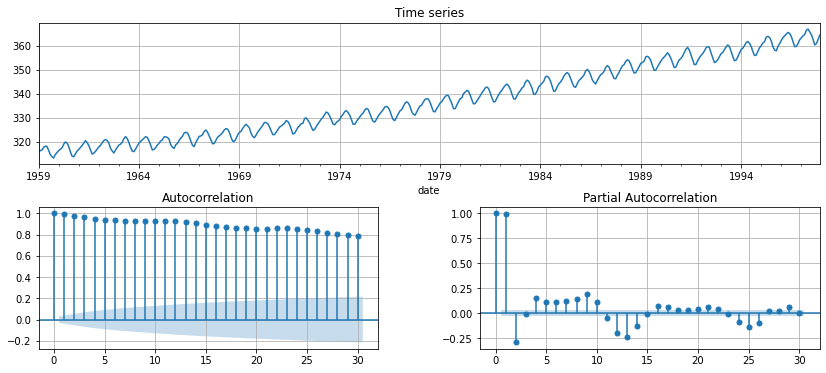

In [61]:
tsplot(co2, lags=30)

In [62]:
adf_test(co2)
kpss_test(co2)

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                   2.321850
p-value                          0.998969
#Lags Used                      13.000000
Number of Observations Used    454.000000
Critical Value (1%)             -3.444836
Critical Value (5%)             -2.867927
Critical Value (10%)            -2.570172
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.935697
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64



/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Data vykazují značné autokorelace a testy naznačují jednotkový kořen a tedy potřebu diferencovat. Vytušit lze roční periodu sezónnosti, zkusíme se ale zbavit trendu a uvidíme dál:

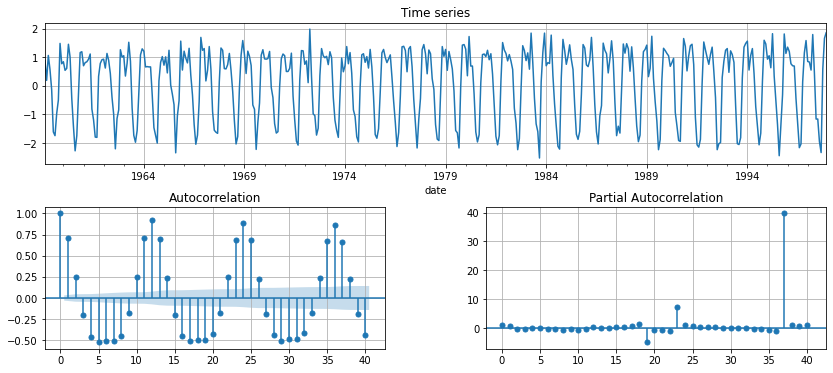

In [63]:
tsplot(co2.diff().dropna(), lags=40)

In [64]:
adf_test(co2.diff().dropna())
kpss_test(co2.diff().dropna())

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                  -5.138087
p-value                          0.000012
#Lags Used                      12.000000
Number of Observations Used    454.000000
Critical Value (1%)             -3.444836
Critical Value (5%)             -2.867927
Critical Value (10%)            -2.570172
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic           0.004153
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64



/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Globálního trendu jsme se zřejmě zbavili. Sezóny jsou nyní v ACF jasně patrné, $s=12$, autokorelace jsou velmi vysoké, zkusíme tedy sezónní diferencování:

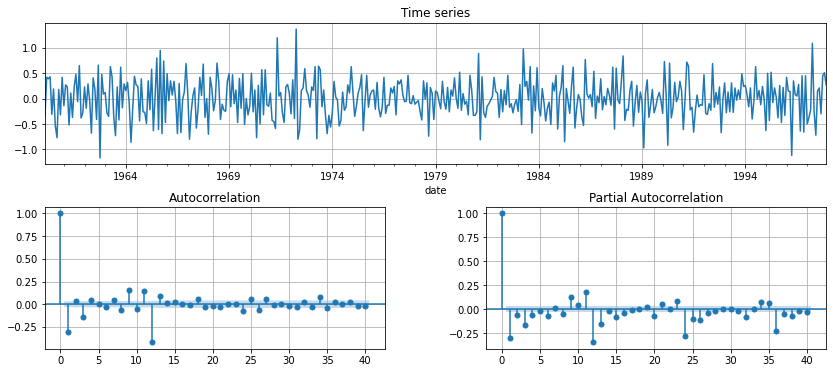

In [65]:
tsplot(co2.diff().diff(12).dropna(), lags=40)

In [66]:
adf_test(co2.diff().diff(12).dropna())
kpss_test(co2.diff().diff(12).dropna())

Results of Dickey-Fuller Test:
H0: Unit root (nonstationarity) present
HA: No unit root
Test Statistic                -7.992255e+00
p-value                        2.456603e-12
#Lags Used                     1.200000e+01
Number of Observations Used    4.420000e+02
Critical Value (1%)           -3.445232e+00
Critical Value (5%)           -2.868101e+00
Critical Value (10%)          -2.570265e+00
dtype: float64

Results of KPSS Test:
H0: Trend stationary
HA: Not trend stationary (has unit root)
Test Statistic            0.036687
p-value                   0.100000
Lags Used                32.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64



/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Nyní to vypadá obstojně. V 1. a 12. zpoždění je výrazná autokorelace "bez" následujících peaků, naopak PACF graf postupně klesá k nule, dal by se tedy vytušit MA vývoj v sezóně i globálně. Budeme tedy zkoušet model SARIMA(0,1,1)(0,1,1)12:

In [75]:
model = sm.tsa.arima.ARIMA(co2, order=(0,1,1),
                           seasonal_order=(0,1,1,12), 
                           trend='n').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                              co2   No. Observations:                  468
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -86.076
Date:                          Tue, 19 Oct 2021   AIC                            178.151
Time:                                  17:44:11   BIC                            190.512
Sample:                              01-31-1959   HQIC                           183.021
                                   - 12-31-1997                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3501      0.043     -8.123      0.000      -0.435      -0.266
ma.S.L12      -0.8506      0.029    -29.578      0.000      -0.907      -0.794
sigma2         0.0826      0.006     13.959      0.000       0.071       0.094
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.79   Prob(JB):                         0.40
Heteroskedasticity (H):               0.93   Skew:                            -0.08
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Analýzy a testy už bychom měli znát. Výše vypadají přívětivě, zkusíme ještě experimentovat v okolí tohoto modelu:

In [76]:
model_alt = sm.tsa.arima.ARIMA(co2, order=(0,1,3),
                           seasonal_order=(0,1,2,12), 
                           trend='n').fit()
print(model_alt.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                   co2   No. Observations:                  468
Model:             ARIMA(0, 1, 3)x(0, 1, [1, 2], 12)   Log Likelihood                 -83.120
Date:                               Tue, 19 Oct 2021   AIC                            178.239
Time:                                       17:44:22   BIC                            202.961
Sample:                                   01-31-1959   HQIC                           187.979
                                        - 12-31-1997                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3366      0.047     -7.230      0.000      -0.428      -0.245
ma.L2      

Zřejmě stanovený model sedí dobře. Podívejme se tedy na diagnostické grafy:

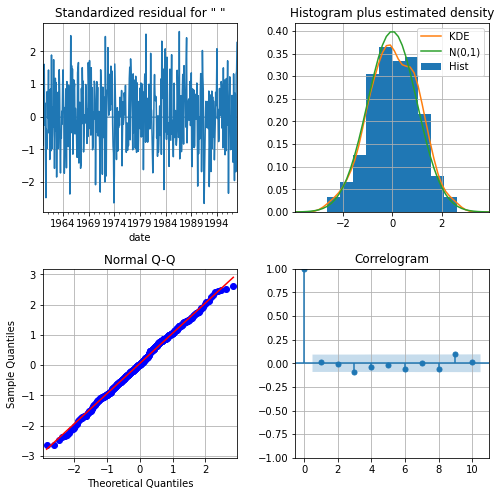

In [77]:
model.plot_diagnostics(figsize=(8,8))
plt.show()

Výsledek je solidní, rezidua jsou prakticky nekorelovaná a relativně slušně kopírují normální rozdělení. Jak asi dopadnou predikce do budoucnosti?

In [90]:
pred_end='2000-01-31'
preds = model.get_prediction(end='2000-01-31')
preds_df = preds.summary_frame()
print(preds_df)

 co2              mean      mean_se  mean_ci_lower  mean_ci_upper
1959-01-31    0.000000  1414.213619   -2771.807759    2771.807759
1959-02-28  315.419992  1000.000080   -1644.544149    2275.384133
1959-03-31  316.310000  1000.000080   -1643.654141    2276.274141
1959-04-30  316.500000  1000.000080   -1643.464141    2276.464141
1959-05-31  317.560000  1000.000080   -1642.404141    2277.524141
...                ...          ...            ...            ...
1999-09-30  364.284699     0.942319     362.437787     366.131611
1999-10-31  364.412647     0.966470     362.518401     366.306893
1999-11-30  365.845425     0.990031     363.904999     367.785851
1999-12-31  367.259309     1.013045     365.273777     369.244841
2000-01-31  368.316823     1.045298     366.268077     370.365570

[493 rows x 4 columns]


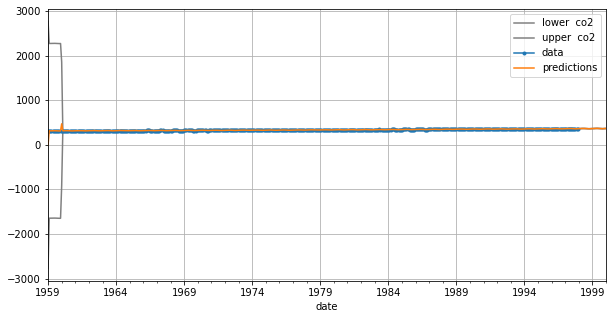

In [91]:
ci = preds.conf_int()

fig = ci.plot(color='grey', figsize=(10, 5))
model.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predictions', fig=fig)
plt.legend()
plt.show()

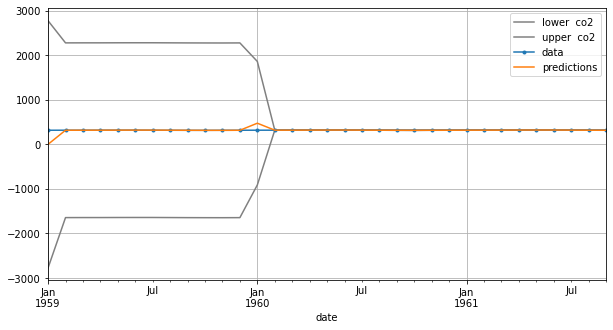

In [112]:
plot_from = '1959'
plot_to = '1961-09'
# plot_to = pred_end  # odkomentovat pro forecasting
fig = ci[plot_from:plot_to].plot(color='grey', figsize=(10, 5))
model.data.orig_endog[plot_from:plot_to].plot(label='data', marker='.', fig=fig)
preds.predicted_mean[plot_from:plot_to].plot(label='predictions', fig=fig)
#plt.ylim(310,325)    # odkomentovat pro zoom na zacatek
plt.legend()
plt.show()

Hezky :)